# Time Series - Differencing, Stationarity, Seasonality & ACF/PACF

# here I use Time Series Analysis to analyse futute gold prices. 

In [1]:
# load all the necessary libraries

import statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter 
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf, pacf
import warnings
warnings.filterwarnings("ignore")

# Set display option to avoid scientific notation in pandas, show up to 5 decimal points
pd.set_option('display.float_format', lambda x: '%.5f' % x)
# and numpy
np.set_printoptions(suppress=True, precision=5)

## Predict Gold Price at Close

Data source: https://www.investing.com/commodities/gold-mini

#### Information on the dataset used

- Price column saves price for 100g of gold in INR (Indian Rupees)
- Date saves daily record of days from January 2014 to March end 2024. 

In [2]:
# Load the gold price dataset
df = pd.read_csv('gold_price.csv')

display(df.head())

,Date,Price,Open,High,Low,Vol.,Change %
0,01/01/2014,"29,542","29,435","29,598","29,340",2.93K,0.25%
1,01/02/2014,"29,975","29,678","30,050","29,678",3.14K,1.47%
2,01/03/2014,"29,727","30,031","30,125","29,539",3.05K,-0.83%
3,01/04/2014,"29,279","29,279","29,279","29,279",NaN,-1.51%
4,01/06/2014,"29,119","29,300","29,395","29,051",24.38K,-0.55%


#### Convert Date column to datetime format and Price to int by removing comma in between

In [3]:
# Convert the 'target_end_date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])
df['Price'] = df['Price'].str.replace(',', '').astype(int)
print(df.head())

        Date  Price    Open    High     Low    Vol. Change %
0 2014-01-01  29542  29,435  29,598  29,340   2.93K    0.25%
1 2014-01-02  29975  29,678  30,050  29,678   3.14K    1.47%
2 2014-01-03  29727  30,031  30,125  29,539   3.05K   -0.83%
3 2014-01-04  29279  29,279  29,279  29,279     NaN   -1.51%
4 2014-01-06  29119  29,300  29,395  29,051  24.38K   -0.55%


#### Plot the time series graph of change of gold price over time

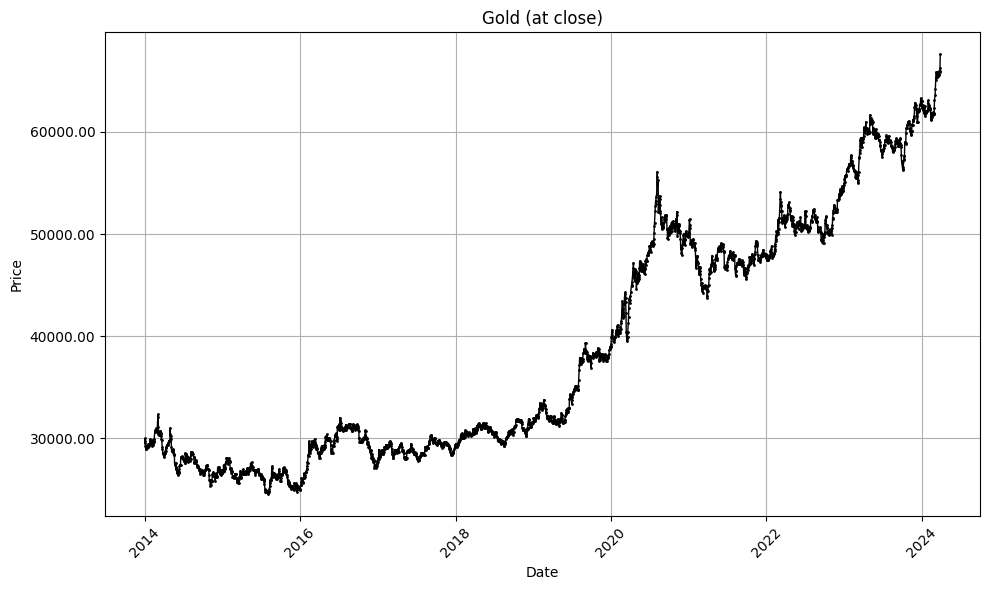

In [4]:
# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Price'], marker='o', linestyle='-', color='black',markersize = 1,linewidth=1)
plt.title('Gold (at close)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
# Manually format y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Using the Augmented Dickey-Fuller (ADF) test to check whether the series is stationary. 

- It is applied on the first-difference of the series
- The null-hypothesis says that there is a unit-root (i.e. it's a random walk or a random walk with drift), and hence a non-stationary process.
- A p-value close to zero tells us the process is stationary.¶

In [5]:
from statsmodels.tsa.stattools import adfuller

# Applying the Augmented Dickey-Fuller test on the 'Price' column of the DataFrame
# Note: We drop the first NaN value that results from differencing
adf_result = adfuller(df['Price'].dropna())

adf_output = pd.Series(adf_result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_result[4].items():
    adf_output[f'Critical Value ({key})'] = value
adf_output

Test Statistic                   1.15645
p-value                          0.99567
#Lags Used                      12.00000
Number of Observations Used   2637.00000
Critical Value (1%)             -3.43283
Critical Value (5%)             -2.86264
Critical Value (10%)            -2.56735
dtype: float64

### The time series is not stationary 
- We can say this since the p-value is high (above the typical significance level of 0.05), so we cannot reject the null hypothesis
- The test statistic is positive indicating the series follows a trend of non stationarity (null hypothesis)

### Stabilising the series' variance via a monotonic transformation. 

- By monotonic transformation we preserve the order of values in the data. So value greater than another in the original data, will remain greater after the transformation.
- We are taking the log of the price as this compresses the very large values as shown in the previous graph. It makes the graph more gradual and transforms absolute changes to percentage changes, making it easier to analyse.

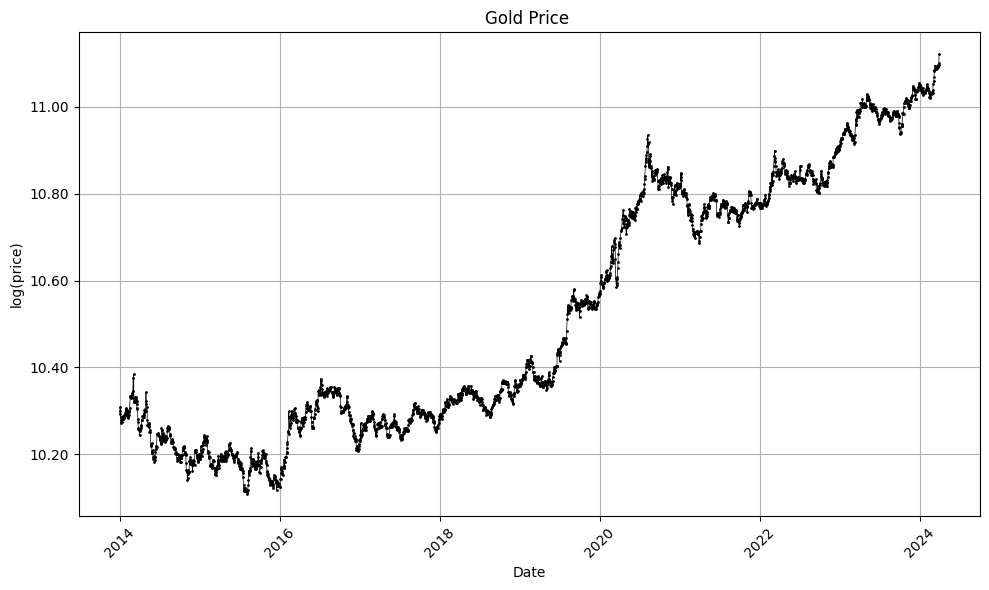

In [6]:
# You can take the log of the series. 
df['log_Price'] = np.log(df['Price'])

# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['log_Price'], marker='o', linestyle='-', color='black',markersize = 1,linewidth= 0.5)
plt.title('Gold Price ')
plt.xlabel('Date')
plt.ylabel('log(price)')
plt.grid(True)
# Manually format y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
from statsmodels.tsa.stattools import adfuller

# Applying the Augmented Dickey-Fuller test on the first-differenced log-transformed series
# Note: We drop the first NaN value that results from differencing
adf_result = adfuller(df['log_Price'].dropna())

adf_output = pd.Series(adf_result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_result[4].items():
    adf_output[f'Critical Value ({key})'] = value

adf_output

Test Statistic                   0.53923
p-value                          0.98602
#Lags Used                       2.00000
Number of Observations Used   2647.00000
Critical Value (1%)             -3.43282
Critical Value (5%)             -2.86263
Critical Value (10%)            -2.56735
dtype: float64

#### The time series is not stationary 
- We can say this since the p-value is high (above the typical significance level of 0.05), so we cannot reject the null hypothesis
- The test statistic is positive indicating the series follows a trend of non stationarity (null hypothesis)

### Calculate and plot the first difference of the log of Gold price. 

- A time-series which is non-stationary can be Differenced to make it more stationary
-  This procedure helps remove trends or seasonal variation.

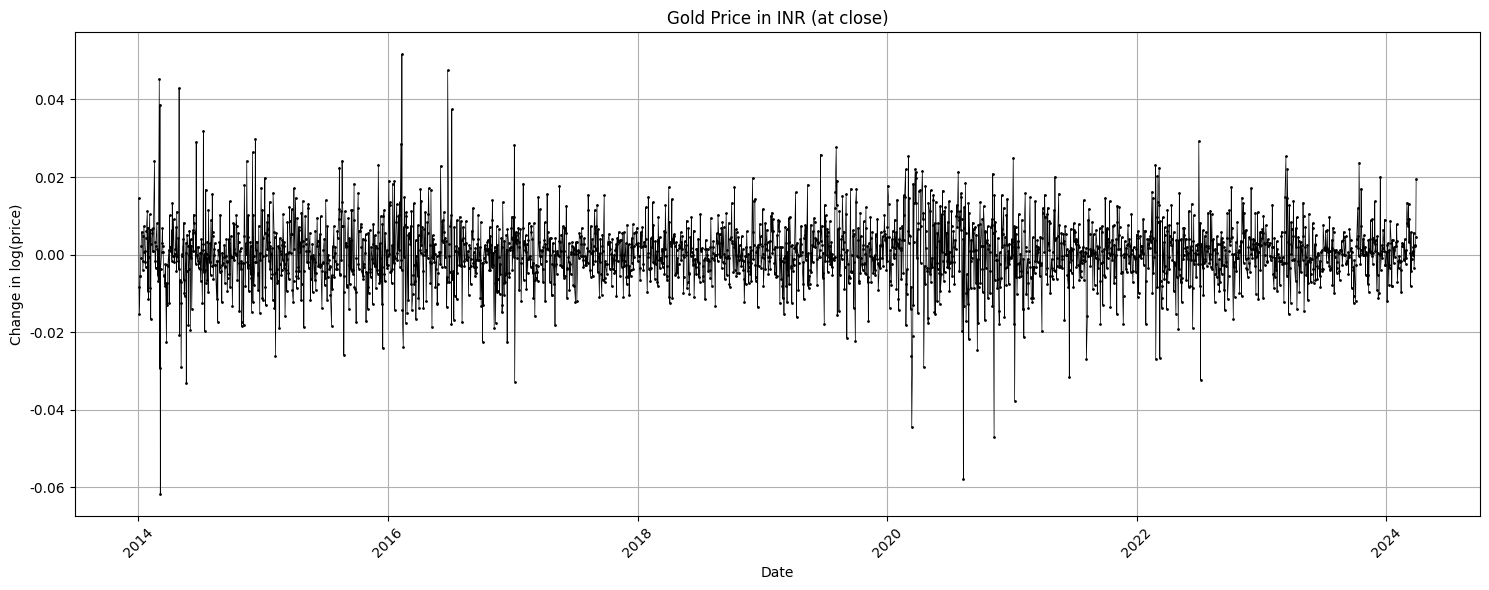

In [8]:
# Calculate the first difference 
df['log_Price_diff'] = df['log_Price'].diff()

# Plotting the first difference of the log-transformed series
plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df['log_Price_diff'], marker='o', linestyle='-', color='black', markersize= 1,linewidth=0.5)
plt.title('Gold Price in INR (at close)')
plt.xlabel('Date')
plt.ylabel('Change in log(price)')
plt.grid(True)
# Manually format y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
from statsmodels.tsa.stattools import adfuller

# Applying the Augmented Dickey-Fuller test on the first-differenced log-transformed series
# Note: We drop the first NaN value that results from differencing
adf_result = adfuller(df['log_Price_diff'].dropna())

adf_output = pd.Series(adf_result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_result[4].items():
    adf_output[f'Critical Value ({key})'] = value

adf_output

Test Statistic                 -35.94559
p-value                          0.00000
#Lags Used                       1.00000
Number of Observations Used   2647.00000
Critical Value (1%)             -3.43282
Critical Value (5%)             -2.86263
Critical Value (10%)            -2.56735
dtype: float64

#### The time series is stationary¶
- Test Statistic is a very negative value thus suggesting against the null hypothesis and support for stationarity
- p-value is 0.00000 (very low) suggesting  against the null hypothesis. So it is stationary

#### Using the ACF and PACF, identify the SARIMA order of this series. 

- To figure order of the AR component we use the ACF graph
- To figure order of the MA component we use the PACF graph

<Figure size 1200x600 with 0 Axes>

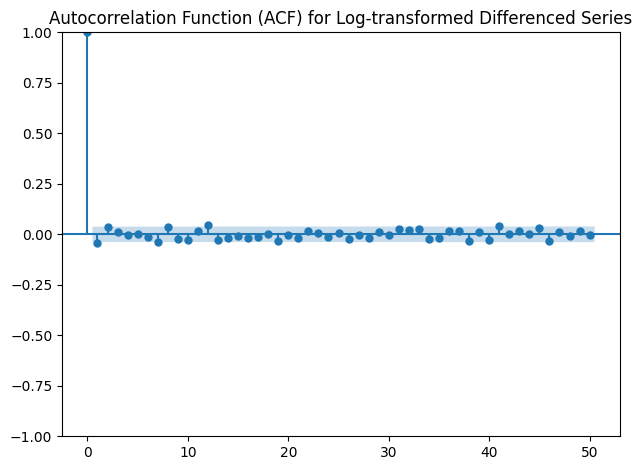

<Figure size 1200x600 with 0 Axes>

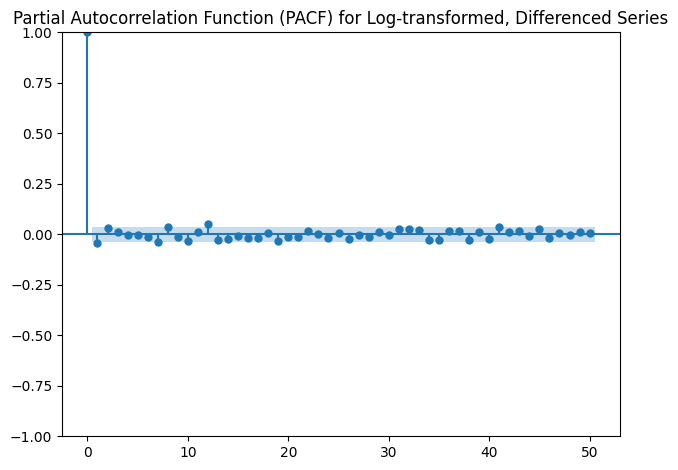

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotting the Autocorrelation Function (ACF)
plt.figure(figsize=(12, 6))
plot_acf(df['log_Price_diff'].dropna(), lags=50, alpha=0.05, title='Autocorrelation Function (ACF) for Log-transformed Differenced Series')
plt.tight_layout()

# Plotting the Partial Autocorrelation Function (PACF)
plt.figure(figsize=(12, 6))
plot_pacf(df['log_Price_diff'].dropna(), lags=50, alpha=0.05, title='Partial Autocorrelation Function (PACF) for Log-transformed, Differenced Series')
plt.tight_layout()

plt.show()

This series is a random walk.

#### Using auto_arima function to estimate an optimal order for the series `on the original scale, before differencing`, and generate a summary of the model. 

The auto_arima function automatically selects the optimal SARIMA model. 
For the model below we can say that the best SARIMA model is ARIMA(1,1,1)(0,0,0)[0]

That is the non-seasonal components are:
- p=1 (the AR component)
- d=1 (degree of differencing)
- q=1 (the MA component)

The seasonal components are:
- P=1  (seasonal AR component)
- D=1 (number of seasonal differences)
- Q=1 (seasonal MA component)

- m=0 (The seasonality component) 

In [11]:
from pmdarima import auto_arima
import pandas as pd

# Note: We drop the first NaN value that results from differencing
series = df['Price'].dropna()
series.index = pd.to_datetime(df['Date'])  # Assuming 'series.index' contains date strings


# Use auto_arima to find the optimal SARIMA model
auto_model = auto_arima(series,
                        start_p=0, start_q=0,
                        max_p=20, max_q=20,  # Maximum p and q
                        #m=4,  # Adjust this based on your seasonality (e.g., 12 for monthly data with annual seasonality)
                        #start_P=0, start_Q=0, 
                        #max_P=20, max_Q=20,
                        seasonal=False,  # Enable search for seasonal parameters
                        #D=1,  # Assuming one seasonal differencing. Adjust as needed.
                        test='adf',  # Use ADF test to find optimal 'd'
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=38241.571, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=38241.741, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=38241.857, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=38244.594, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=38243.127, Time=0.32 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.489 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2650
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -19118.786
Date:                Tue, 02 Apr 2024   AIC                          38241.571
Time:                        11:32:42   BIC                          38253.335
Sample:                             0   HQIC                         38245.829
                               - 2650                                  

#### Time Series Model Evaluation: Rolling Forecast Origin

- Now that I have fitted the model, I will test its forecasting abilities.

- k-fold cross validation cannot be applied on this data as we need to respect the chronological order of the data.
- Hence, the evaluation method we use are **rolling forecast origin** and **expanding window** approaches, designed specifically for the sequential evaluation of time-series models.

##### Rolling Forecast Origin: Leveraging Temporal Dynamics

- This approach is unfolds the data piece by piece, using each new piece to test the forecasting ability of the model trained on all the preceding pieces.
- It first splits the data in training and testing. It follows a temporal splitting technique. Then it trains the ARMA model on the training data.
- The rolling forecast technique predicts the immediate next time point in the sequence and incorporates that point into the training dataset to make the next point prediction. This process continues till the last point.
- The performance of the model and the forecasring accuracy is assessed by comparing the model's prediction vs the actual prediction. I use metrics like the Mean Squared Error (MSE) to measure the model's precision.
- This cycle is repeated across the testing dataset and thus offers insights into its reliability and robustness.

#### Using a 'Rolling Origin' type forecast, estimate the expected one-step-ahead generalisation error.

In [12]:
# Extract the order (p, d, q)
order = auto_model.order

# Extract the seasonal order (P, D, Q, m)
seasonal_order = auto_model.seasonal_order

print(f"Non-seasonal order: {order}")
print(f"Seasonal order: {seasonal_order}")

Non-seasonal order: (0, 1, 0)
Seasonal order: (0, 0, 0, 0)


In [13]:
# Split the dataset into training and test sets
train_size = int(len(series) * 0.95)
series_train, series_test = series[:train_size], series[train_size:]

history = series_train.values.copy()
predictions = []
confidence_intervals = []

# Rolling forecast origin
for t in range(len(series_test)):
    # Fit the SARIMA model on the history
    model = SARIMAX(history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)  # Suppress fitting messages
    
    # Forecast the next point and get the 95% confidence interval
    forecast_result = model_fit.get_forecast(steps=1)
    yhat = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int(alpha=0.05)  # 95% confidence interval
    
    predictions.append(yhat[0])  # Access forecast result correctly
    confidence_intervals.append(conf_int[0])  # Store confidence interval for each forecast
    
    # Correctly add the actual observation from series_test to history for the next loop
    actual_obs = series_test.iloc[t]  # Use .iloc[t] to correctly access the observation
    history = np.append(history, actual_obs)

Test RMSE: 385.19022739186346


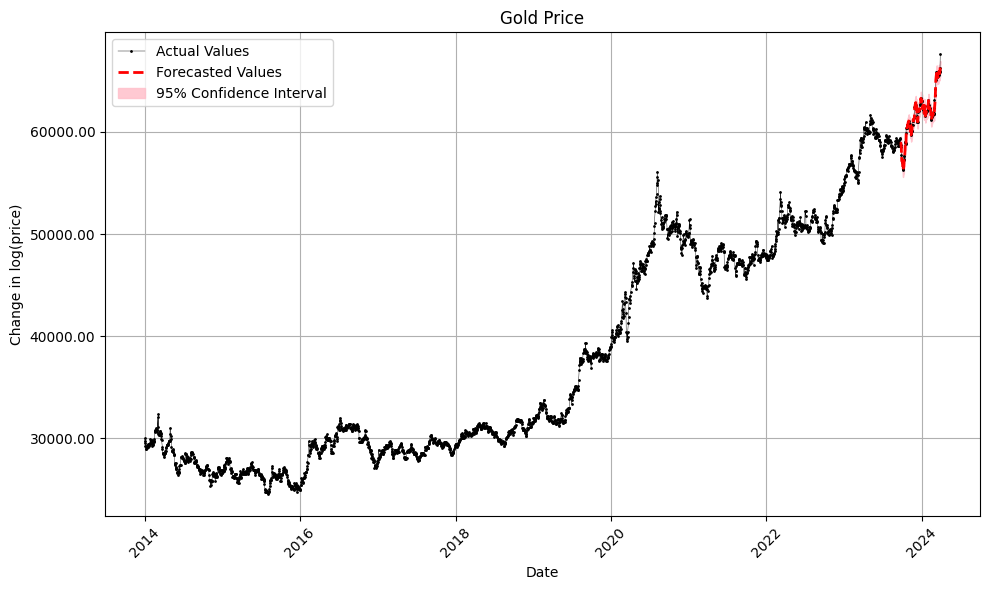

In [14]:
# Calculate RMSE
rmse = np.sqrt(np.mean((predictions - series_test)**2))
print(f'Test RMSE: {rmse}')

# Plotting the forecast along with the actual series and confidence intervals
plt.figure(figsize=(10, 6))
# Plotting the entire original series
plt.plot(series.index, series, marker='o', linestyle='-', color='black', markersize=1, linewidth=0.3, label='Actual Values')

# Plotting the forecasted values on the test set
plt.plot(series_test.index, predictions, label='Forecasted Values', color='red', linestyle='--', linewidth=2)

# Extracting lower and upper confidence bounds
lower_bounds = [ci[0] for ci in confidence_intervals]
upper_bounds = [ci[1] for ci in confidence_intervals]

# Plotting the confidence interval
plt.fill_between(series_test.index, lower_bounds, upper_bounds, color='pink', alpha=0.85, label='95% Confidence Interval')

plt.title('Gold Price')
plt.xlabel('Date')
plt.ylabel('Change in log(price)')
plt.grid(True)
# Manually format y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### Part 2: Dataset on milk production to check seasonality

Data source: https://github.com/plotly/datasets/blob/master/monthly-milk-production-pounds.csv

This dataset saves the amount of milk (in pounds) a cow produces per month. The dataset contains data from January 1962 to December 1975

In [108]:
# Load milk dataset
milk = pd.read_csv('monthly-milk-production-pounds.csv',index_col='Month')
milk.index = pd.to_datetime(milk.index)
milk.columns = ['Production']
print(milk.head())

            Production
Month                 
1962-01-01         589
1962-02-01         561
1962-03-01         640
1962-04-01         656
1962-05-01         727


#### Plot the series

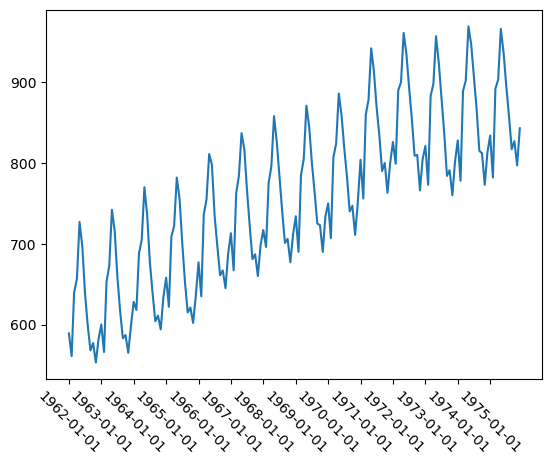

In [75]:
# Plot the time series to check for trends or seasonality.
plt.plot(milk)
plt.xticks(milk.index[::12], rotation=-45)
plt.show()  

From the graph we can see that the amount of milk production follows a repeating pattern every year. Also, there is a gradual increase in the amount of milk cows produce over the years.

In [118]:
from statsmodels.tsa.stattools import adfuller

# Applying the Augmented Dickey-Fuller test on the first-differenced log-transformed series
# Note: We drop the first NaN value that results from differencing
adf_result = adfuller(milk['Production'].dropna())

adf_output = pd.Series(adf_result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_result[4].items():
    adf_output[f'Critical Value ({key})'] = value

adf_output

Test Statistic                 -1.30381
p-value                         0.62743
#Lags Used                     13.00000
Number of Observations Used   154.00000
Critical Value (1%)            -3.47354
Critical Value (5%)            -2.88050
Critical Value (10%)           -2.57688
dtype: float64

### The time series is not stationary 
- The p-value (0.62743) is high (above the typical significance level of 0.05), so we cannot reject the null hypothesis
- The test statistic is positive indicating the series follows a trend of non stationarity (null hypothesis)

#### Decomposing Time Series Data

As we see in the graph, there is an observable seasonal effect. This can be removed by subtracting the data point from the same point one season ago (which is 12 months here). This method helps to smooth out the peaks and troughs that occur at the same time each year.

There is a global trend of the amount of milk production increasing over the years. To eliminate this effect, we subtract each data point from the one before it, to level out the persistent upward drift in the data over time.

Through these steps of seasonal and regular differencing, we are able to stabilise the mean of the time series so that the transformed data looks consistent over time, without a trend or seasonality.

#### Using the `sm.tsa` built-in `seasonal_decompose()` to decompose the series into its constituent parts. 

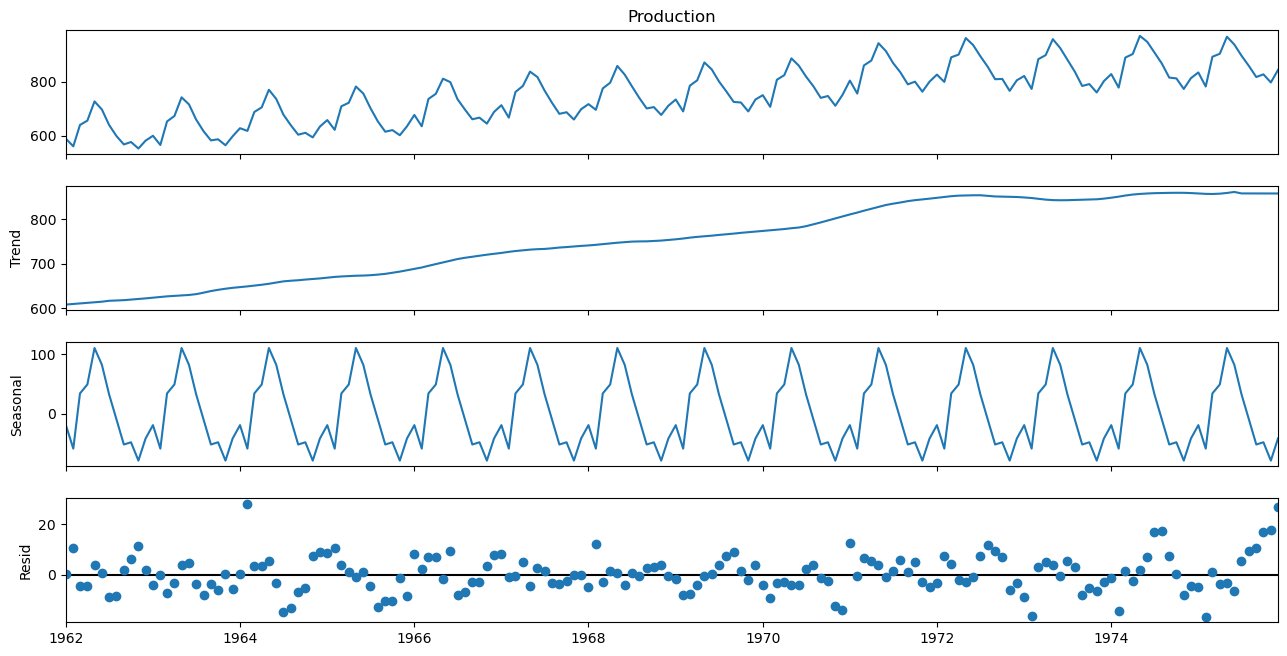

In [77]:
decomposition = sm.tsa.seasonal_decompose(milk['Production'], model='additive', extrapolate_trend=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = decomposition.plot()
fig.set_size_inches(14, 7)
plt.show()

As seen above, we can observe the:

- general trend over the years
- seasonal trend showing the pattern repeating every 12 months
- residual data showing how the data looks like after removing the general and seasonal trend

#### Taking a first difference of the series

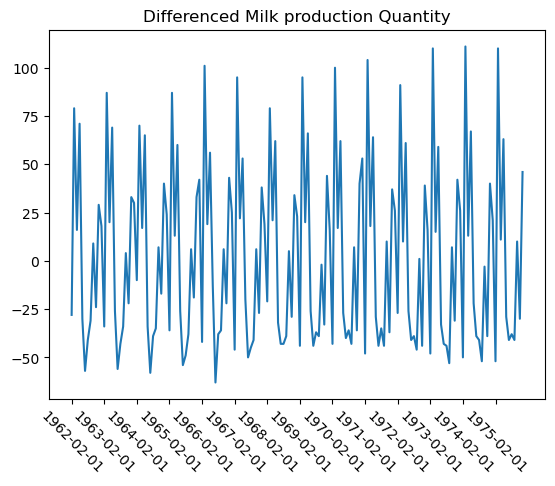

In [78]:
# Differencing
milk_diff = milk.diff().dropna()

# Plot the differenced time series
plt.plot(milk_diff)
plt.title('Differenced Milk production Quantity')
plt.xticks(milk_diff.index[::12], rotation=-45)
plt.show()

#### Taking a seasonal (yearly) first difference

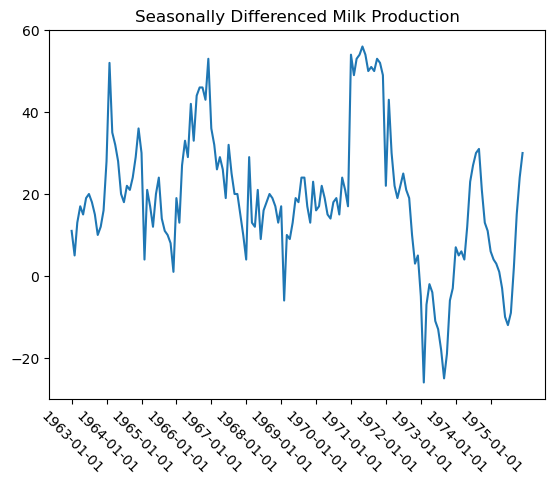

In [79]:
# there is yearly seasonality so I difference by that period:
seasonal_diff = milk.diff(12).dropna()

# Plot the seasonally differenced time series
plt.plot(seasonal_diff)
plt.title('Seasonally Differenced Milk Production')
plt.xticks(seasonal_diff.index[::12], rotation=-45)
plt.show()

#### Applying both the differencing and seasonal differencing to the time series

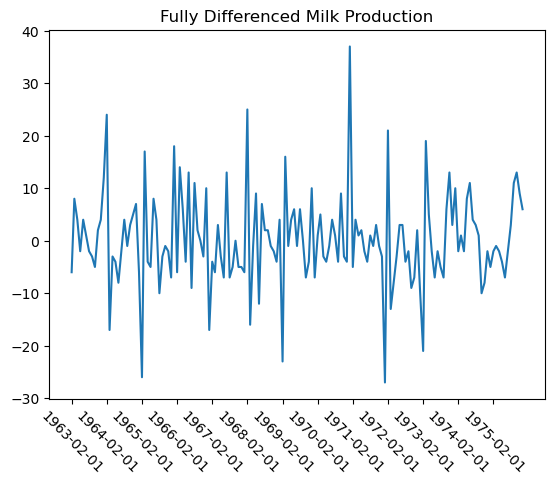

In [80]:
both_diff = milk_diff.diff(12).dropna()

# Plot the fully differenced time series
plt.plot(both_diff)
plt.title('Fully Differenced Milk Production')
plt.xticks(both_diff.index[::12], rotation=-45)
plt.show()

The graph looks more stationary without any seasonal trend or general drift

#### Checking if the residual series is stationary

In [119]:
from statsmodels.tsa.stattools import adfuller

# Applying the Augmented Dickey-Fuller test on the first-differenced log-transformed series
# Note: We drop the first NaN value that results from differencing
adf_result = adfuller(both_diff)

adf_output = pd.Series(adf_result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_result[4].items():
    adf_output[f'Critical Value ({key})'] = value

adf_output

Test Statistic                 -5.03800
p-value                         0.00002
#Lags Used                     11.00000
Number of Observations Used   143.00000
Critical Value (1%)            -3.47693
Critical Value (5%)            -2.88197
Critical Value (10%)           -2.57767
dtype: float64

#### The time series is stationary¶
- Test Statistic is a negative value thus suggesting against the null hypothesis and support for stationarity
- p-value is 0.00002 (very low) suggesting  against the null hypothesis. So it is stationary

#### Checking the ACF and PACF of the residual series to understand what model seems to make sense? 

<Figure size 1200x600 with 0 Axes>

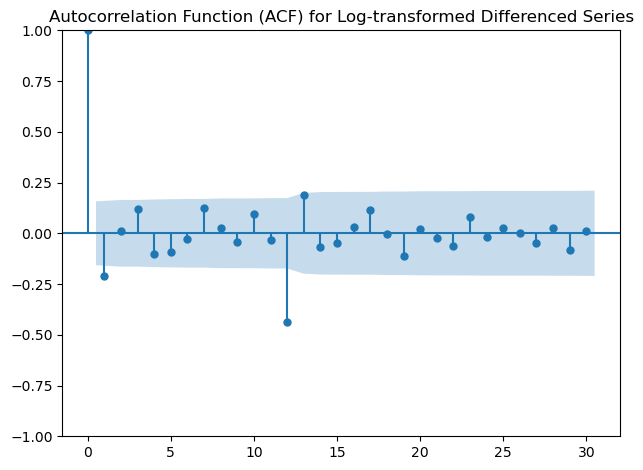

<Figure size 1200x600 with 0 Axes>

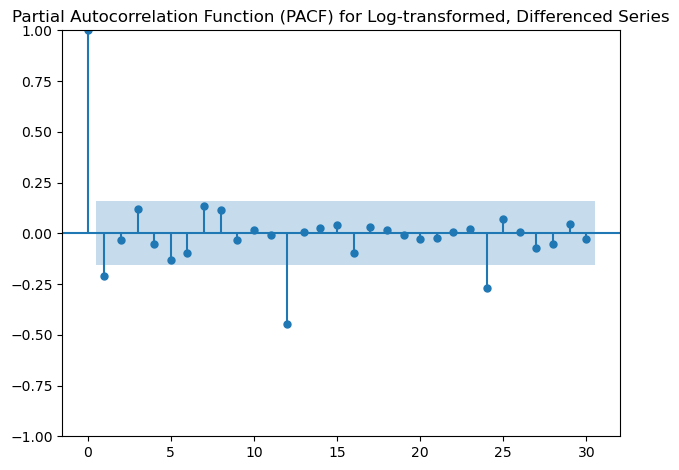

In [82]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotting the Autocorrelation Function (ACF)
plt.figure(figsize=(12, 6))
plot_acf(both_diff, lags=30, alpha=0.05, title='Autocorrelation Function (ACF) for Log-transformed Differenced Series')
plt.tight_layout()

# Plotting the Partial Autocorrelation Function (PACF)
plt.figure(figsize=(12, 6))
plot_pacf(both_diff, lags=30, alpha=0.05, title='Partial Autocorrelation Function (PACF) for Log-transformed, Differenced Series')
plt.tight_layout()

plt.show()

From the ACF and PACF graphs we can say that the time series is a white noise. 
There is only one autocorrelation that is significantly non-zero at a lag of 0. So, the time series is random.

#### Using auto_arima to find an optimal seasonal model -- here we see a non-zero seasonal compoinent

In [121]:
# Note: We drop the first NaN value that results from differencing
series = milk['Production']

# Use auto_arima to find the optimal SARIMA model
auto_model = auto_arima(series,
                        start_p=0, start_q=0,
                        max_p=20, max_q=20,  # Maximum p and q
                        m=12,  # Adjust this based on your seasonality (e.g., 12 for monthly data with annual seasonality)
                        start_P=0, start_Q=0, 
                        max_P=20, max_Q=20,
                        seasonal=True,  # Enable search for seasonal parameters
                        D=1,  # Assuming one seasonal differencing. Adjust as needed.
                        test='adf',  # Use ADF test to find optimal 'd'
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1119.969, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1081.584, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1066.296, Time=0.08 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1114.995, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1068.030, Time=0.18 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1067.976, Time=0.31 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1082.123, Time=0.05 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.09 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1072.280, Time=0.06 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1068.064, Time=0.15 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1067.796, Time=0.20 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1066.207, Time=0.28 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1114.845, Time=0.02 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1067.913, Time=0.14 sec
 ARIMA(1,1,0)(0,1,2)[12]

#### Performing a the Rolling-origin forecast to predict the one-step-ahead generalisation error, under a scenario where we receive updates on our data. 

Explanation of rolling origin forecast is given above

In [122]:
# Extract the order (p, d, q)
order = auto_model.order

# Extract the seasonal order (P, D, Q, m)
seasonal_order = auto_model.seasonal_order

print(f"Non-seasonal order: {order}")
print(f"Seasonal order: {seasonal_order}")

Non-seasonal order: (1, 1, 0)
Seasonal order: (0, 1, 1, 12)


In [123]:
# Splitting the dataset into training and test sets
train_size = int(len(series) * 0.8)
series_train, series_test = series[:train_size], series[train_size:]

history = series_train.values.copy()  # Ensure 'history' is a numpy array for model fitting
predictions = []
confidence_intervals = []

# Rolling forecast origin
for t in range(len(series_test)):
    # Fit the SARIMA model on the history
    model = SARIMAX(history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)  # Suppress fitting messages
    
    # Forecast the next point and get the 95% confidence interval
    forecast_result = model_fit.get_forecast(steps=1)
    yhat = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int(alpha=0.05)  # 95% confidence interval
    
    predictions.append(yhat[0])  # Access forecast result correctly
    confidence_intervals.append(conf_int[0])  # Store confidence interval for each forecast
    
    # Correctly add the actual observation from series_test to history for the next loop
    actual_obs = series_test.iloc[t]  # Use .iloc[t] to correctly access the observation
    history = np.append(history, actual_obs)

Test RMSE: 6.278802713179736


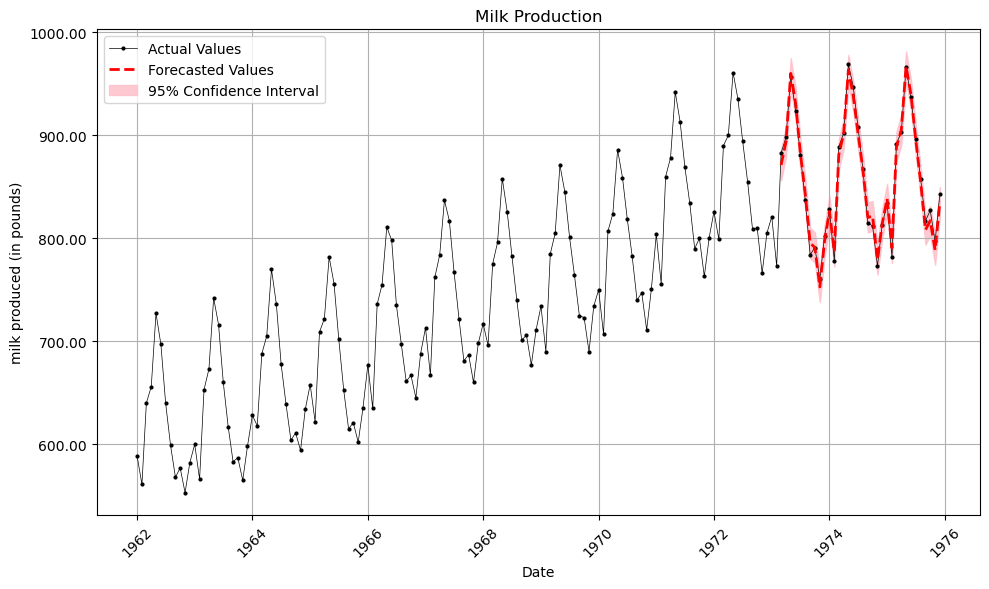

In [124]:
# Calculate RMSE
rmse = np.sqrt(np.mean((predictions - series_test)**2))
print(f'Test RMSE: {rmse}')

# Plotting the forecast along with the actual series and confidence intervals
plt.figure(figsize=(10, 6))
# Plotting the entire original series
plt.plot(series.index, series, marker='o', linestyle='-', color='black', markersize=2, linewidth=0.5, label='Actual Values')

# Plotting the forecasted values on the test set
plt.plot(series_test.index, predictions, label='Forecasted Values', color='red', linestyle='--', linewidth=2)

# Extracting lower and upper confidence bounds
lower_bounds = [ci[0] for ci in confidence_intervals]
upper_bounds = [ci[1] for ci in confidence_intervals]

# Plotting the confidence interval
plt.fill_between(series_test.index, lower_bounds, upper_bounds, color='pink', alpha=0.85, label='95% Confidence Interval')

plt.title('Milk Production')
plt.xlabel('Date')
plt.ylabel('milk produced (in pounds)')
plt.grid(True)

# Formatting y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))

# Ensuring dates are nicely formatted and readable
plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()